# Data from the web

In [1]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import json
from io import StringIO

import time

In [2]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool, Title
from bokeh.models.tickers import FixedTicker
from bokeh.models.formatters import FuncTickFormatter
output_notebook()

Loading BokehJS ...

# Table of Contents
 <p><div class="lev1"><a href="#QS-World-University-Ranking"><span class="toc-item-num">1&nbsp;&nbsp;</span>QS World University Ranking</a></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(worldwide)"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ratio of faculty members and international students (worldwide)</a></div></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(by-region)"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ratio of faculty members and international students (by region)</a></div></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(by-country)"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ratio of faculty members and international students (by country)</a></div></div>
 <div class="lev1"><a href="#Times-Higher-Education-University-Ranking"><span class="toc-item-num">2&nbsp;&nbsp;</span>Times Higher Education University Ranking</a></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(worldwide)"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ratio of faculty members and international students (worldwide)</a></div></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(by-region)"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ratio of faculty members and international students (by region)</a></div></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(by-country)"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ratio of faculty members and international students (by country)</a></div></div>
 <div class="lev1"><a href="#Merging-the-QS-and-the-THE-rankings"><span class="toc-item-num">3&nbsp;&nbsp;</span>Merging the QS and the THE rankings</a></div>
 <div class="lev1"><a href="#Correlations"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlations</a></div>

# GETTING THE DATA


When we do a little retro engenering on the web sites of www.topuniversities.com and www.timeshighereducation.com, we see that both load a json file with all the data we want. In this homework we will load the json and do a Data analyse.



# QS World University Ranking
### www.topuniversities.com

Here if we look at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt
, we have alt the data in json format.

Firstly, we load the json :

In [3]:
url_QS = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"
r =  requests.get(url_QS)
print(r.status_code)

200


Now we interpret the json and put it in a DataFrame

In [4]:
json = json.load(StringIO(r.text))
dataQS = pd.DataFrame(json['data'])

We drop the data which is irrelevant for us.

In [5]:
dataQS.drop("logo",axis=1,inplace=True)
dataQS.drop("guide",axis=1,inplace=True)
dataQS.drop("stars",axis=1,inplace=True)
dataQS.drop("core_id",axis=1,inplace=True)
dataQS.head()

,cc,country,nid,rank_display,region,score,title,url
0,US,United States,294850,1,North America,100,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,US,United States,297282,2,North America,98.7,Stanford University,/universities/stanford-university
2,US,United States,294270,3,North America,98.4,Harvard University,/universities/harvard-university
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,GB,United Kingdom,294561,5,Europe,95.6,University of Cambridge,/universities/university-cambridge


Now that we have the information about each university as well as the URL of their web page, we can retrieve the number of student in each university.

We only keep the top-200 universities. Besides, running the script would otherwise take too much time (!)

In [6]:
#we do not use the ranks since some universities have equal rank
dataQS.score = pd.to_numeric(dataQS.score)
dataQS = dataQS.nlargest(200, 'score')

#### Script

In [7]:
#use async for more efficiency
import asyncio

def getnumber(soup,mainclass):
    """ Get the number in div class mainclass in the dom of html page"""
    mainclass_div = soup.findAll('div',{"class":mainclass})
    # if mainclass not found , number ==0
    if(len(mainclass_div)==0):
        return 0
    else :
        return int(mainclass_div[0].findAll("div",{"class":"number"})[0].text.replace(",",""))

    
def setnumber(index,url):
    url_univ = 'https://www.topuniversities.com/'+url
    print(index,url)
    
    # get the web page of the university
    r =  requests.get(url_univ)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # we get number of students, teachers and international staff and students
    return [ (index,"number of students", getnumber(soup,"students-main")),
    (index,"number of international students", getnumber(soup,"int-students-main")),
    (index,"number of faculty members", getnumber(soup,"total faculty")),
    (index,"number of international faculty members",getnumber(soup,"inter faculty"))]

In [8]:
async def main():
    loop = asyncio.get_event_loop()
    futures = [
        loop.run_in_executor(
            None, 
            setnumber, 
            index,
            url
        )
        for index,url in zip(dataQS.index, dataQS["url"])
    ]
    
    for response in await asyncio.gather(*futures):
        for tuble in response : 
            dataQS.set_value(*tuble)

In [9]:
dataQS["number of students"] = 0
dataQS["number of international students"]= 0
dataQS["number of faculty members"] = 0
dataQS["number of international faculty members"] = 0

#loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for index,url in zip(dataQS.index, dataQS["url"]):
     for tuble in setnumber(index,url) :
            dataQS.set_value(*tuble)

0 /universities/massachusetts-institute-technology-mit
1 /universities/stanford-university
2 /universities/harvard-university
3 /universities/california-institute-technology-caltech
4 /universities/university-cambridge
5 /universities/university-oxford
6 /universities/ucl-university-college-london
7 /universities/imperial-college-london
8 /universities/university-chicago
9 /universities/eth-zurich-swiss-federal-institute-technology
10 /universities/nanyang-technological-university-singapore-ntu
11 /universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl
12 /universities/princeton-university
13 /universities/cornell-university
14 /universities/national-university-singapore-nus
15 /universities/yale-university
16 /universities/johns-hopkins-university
17 /universities/columbia-university
18 /universities/university-pennsylvania
19 /universities/australian-national-university
20 /universities/university-michigan
21 /universities/duke-university
22 /universities/university-edi

188 /universities/university-reading
189 /universities/indian-institute-science-iisc-bangalore
190 /universities/university-cape-town
191 /universities/scuola-normale-superiore-di-pisa
192 /universities/scuola-superiore-santanna-pisa-di-studi-universitari-e-di-perfezionamento
193 /universities/keio-university-cems-mim
194 /universities/stockholm-university
195 /universities/universitat-aut%C3%B2noma-de-barcelona
196 /universities/texas-am-university
197 /universities/instituto-tecnol%C3%B3gico-y-de-estudios-superiores-de-monterrey
198 /universities/maastricht-university
199 /universities/universidad-de-chile


In [10]:
dataQS.head()

,cc,country,nid,rank_display,region,score,title,url,number of students,number of international students,number of faculty members,number of international faculty members
0,US,United States,294850,1,North America,100.0,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,11067,3717,2982,1679
1,US,United States,297282,2,North America,98.7,Stanford University,/universities/stanford-university,15878,3611,4285,2042
2,US,United States,294270,3,North America,98.4,Harvard University,/universities/harvard-university,22429,5266,4350,1311
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255,647,953,350
4,GB,United Kingdom,294561,5,Europe,95.6,University of Cambridge,/universities/university-cambridge,18770,6699,5490,2278


### Ratio of faculty members and international students (worldwide)

In [11]:
def plot_top_n(dataframe, column, top, ascending, title, xlabel, ylabel, url):
    ax = dataframe.sort_values(column, ascending=ascending).head(top) \
               .plot(y=column, 
                     x='title', 
                     kind='bar', 
                     grid=True, 
                     figsize=(20, 6), 
                     title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.gca().set_position((0.0, 0.9, 0.8, 0.8))
    plt.figtext(0.0, 0.0, "Data from: " + url);

#### Top universities with the lowest Students:Staff ratio

In [12]:
dataQS['Students:Staff Ratio'] = dataQS['number of students'] / dataQS['number of faculty members']

The *Students:Staff Ratio* is sorted in increasing order: a high number of staff per student is perceived as providing higher quality education.

In [13]:
dataQS.sort_values('Students:Staff Ratio', ascending=True)

,cc,country,nid,rank_display,region,score,title,url,number of students,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255,647,953,350,2.366212
15,US,United States,297177,16,North America,90.4,Yale University,/universities/yale-university,12402,2469,4940,1708,2.510526
5,GB,United Kingdom,294654,6,Europe,95.3,University of Oxford,/universities/university-oxford,19720,7353,6750,2964,2.921481
4,GB,United Kingdom,294561,5,Europe,95.6,University of Cambridge,/universities/university-cambridge,18770,6699,5490,2278,3.418944
16,US,United States,294184,17,North America,89.8,Johns Hopkins University,/universities/johns-hopkins-university,16146,4105,4462,1061,3.618557
1,US,United States,297282,2,North America,98.7,Stanford University,/universities/stanford-university,15878,3611,4285,2042,3.705484
0,US,United States,294850,1,North America,100.0,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,11067,3717,2982,1679,3.711268
185,US,United States,297494,186,North America,49.3,University of Rochester,/universities/university-rochester,9636,2805,2569,488,3.750876
18,US,United States,297569,19,North America,88.7,University of Pennsylvania,/universities/university-pennsylvania,20639,4250,5499,1383,3.753228
17,US,United States,294519,18,North America,88.9,Columbia University,/universities/columbia-university,25045,8105,6189,913,4.046696


For readability, we only display the top-60 universities ranked from lowest to highest *Students:Staff Ratio*.

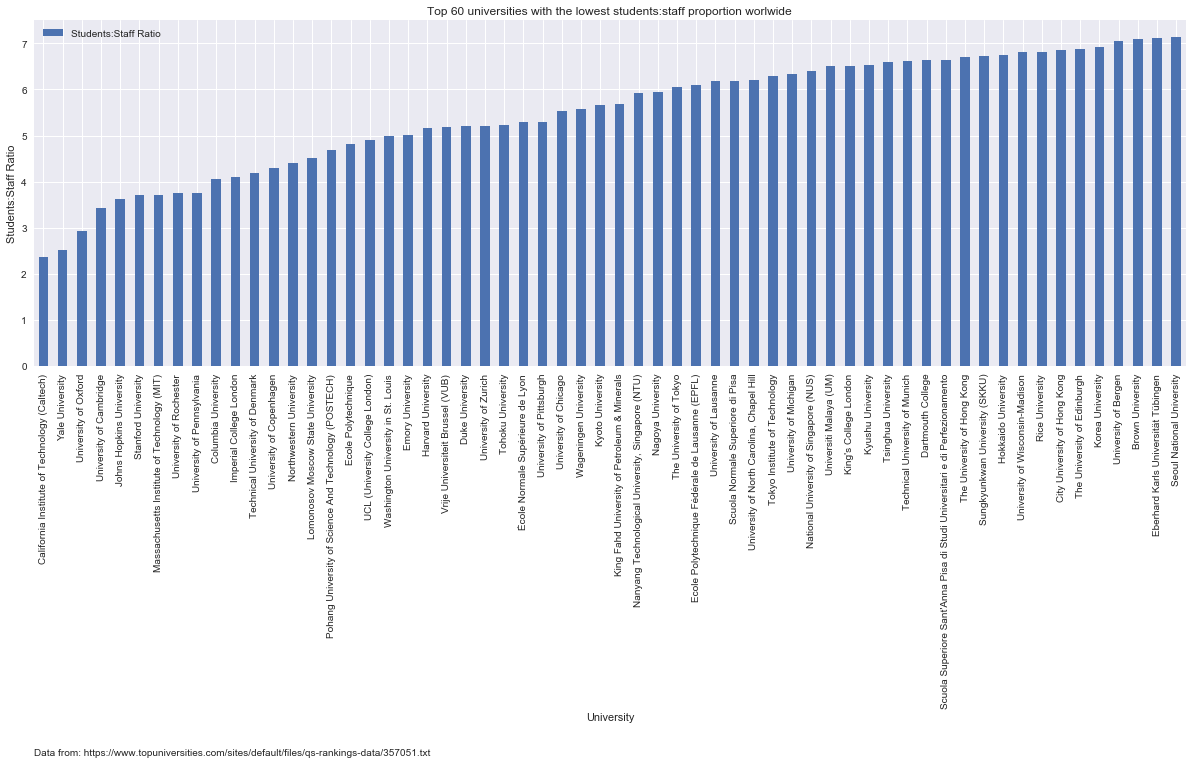

In [14]:
top = 60
plot_top_n(dataQS, 'Students:Staff Ratio', top, True, 
         'Top ' + str(top) + ' universities with the lowest students:staff proportion worlwide',
         'University', 'Students:Staff Ratio', url_QS)

The top-10 universities with the lowest *Students:Staff Ratio* are located in either Europe or North America, with roughly 4 or less students per staff. 

#### Top universities with the highest international students proportion

In [15]:
dataQS['Students international:Students Ratio'] = dataQS['number of international students'] / dataQS['number of students'] 

Inversely, the *Students international:Students Ratio* is sorted in decreasing order: a high proportion of international students is perceived as providing a higher interculturality in a university.

In [16]:
dataQS.sort_values('Students international:Students Ratio', ascending=False)

,cc,country,nid,rank_display,region,score,title,url,number of students,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio,Students international:Students Ratio
34,GB,United Kingdom,294016,35,Europe,81.8,London School of Economics and Political Scien...,/universities/london-school-economics-politica...,9760,6748,1088,687,8.970588,0.691393
11,CH,Switzerland,294481,12,Europe,91.2,Ecole Polytechnique Fédérale de Lausanne (EPFL),/universities/ecole-polytechnique-f%C3%A9d%C3%...,10343,5896,1695,1300,6.102065,0.570047
7,GB,United Kingdom,294030,8,Europe,93.7,Imperial College London,/universities/imperial-college-london,16090,8746,3930,2071,4.094148,0.543567
198,NL,Netherlands,293985,200,Europe,47.9,Maastricht University,/universities/maastricht-university,16385,8234,1277,502,12.830854,0.502533
47,US,United States,294555,=47,North America,78.6,Carnegie Mellon University,/universities/carnegie-mellon-university,13356,6385,1342,425,9.952310,0.478062
6,GB,United Kingdom,294014,7,Europe,94.6,UCL (University College London),/universities/ucl-university-college-london,31080,14854,6345,2554,4.898345,0.477928
91,GB,United Kingdom,297285,92,Europe,65.3,University of St Andrews,/universities/university-st-andrews,8800,4030,1140,485,7.719298,0.457955
41,AU,Australia,294861,=41,Oceania,80.4,The University of Melbourne,/universities/university-melbourne,42182,18030,3311,1477,12.739958,0.427434
126,GB,United Kingdom,294022,127,Europe,58.3,Queen Mary University of London,/universities/queen-mary-university-london,16135,6806,1885,801,8.559682,0.421816
25,HK,Hong Kong,294256,26,Asia,85.5,The University of Hong Kong,/universities/university-hong-kong,20214,8230,3012,2085,6.711155,0.407144


Again, for readability, we only display the top-60 universities scoring highest in the *Students international:Students Ratio*.

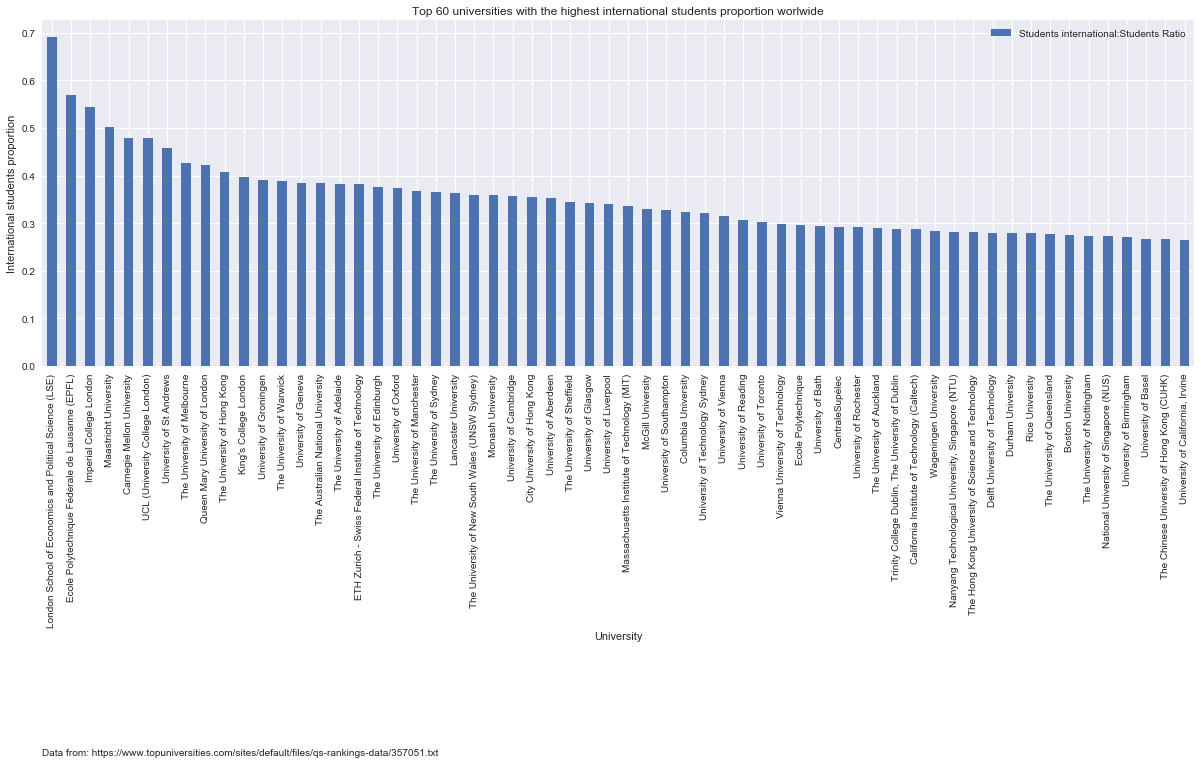

In [17]:
top = 60
plot_top_n(dataQS, 'Students international:Students Ratio', top, False, 
         'Top ' + str(top) + ' universities with the highest international students proportion worlwide',
         'University', 'International students proportion', url_QS)

The top-5 universities with the highest international students proportion are located in Europe or North America. Among the top-10 however, one can be found in Australia and the other in Hong Kong.
For the top-4 universities, the international students proportion exceeds 50%.

#### Plotting functions

In [18]:
def average_plot(dataframe, column, by, title, xlabel, ylabel, url):
    ax =  dataframe.groupby(by).mean().sort_values(column, ascending=False)[column] \
    .plot(kind='bar', figsize=(10,4))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.gca().set_position((0.0, 0.5, 0.8, 0.8))
    plt.figtext(0.0, 0.0, "Data from: " + url);

In [178]:
def boxplot(dataframe, column, by, title, xlabel, ylabel, orientation, url):
    ax = dataframe.boxplot(column=column, by=by, grid=True, figsize=(10,5), vert=(orientation == 'vertical'))
    ax.set_title(title)
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    if(orientation == 'vertical'): 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.gca().set_position((0.0, 0.4, 0.8, 0.8))
    if(orientation == 'horizontal'):
        if(type(ylabel) is str): 
            ax.invert_yaxis()
        plt.gca().set_position((0.0, 0.2, 0.8, 0.8))
    ax.get_figure().suptitle("")
    
    plt.figtext(0.0, 0.0, "Data from: " + url);

In [20]:
def hover_scatter_plot(source, hover, title, xlabel, ylabel, xtickslabels, ytickslabels, orientation, url): 
    p = figure(plot_width=1000, plot_height=400, tools=[hover],
           title=title,
           x_axis_label=xlabel,
           y_axis_label=ylabel)
    p.circle('x', 'y', size=6, source=source)

    if(orientation == 'vertical'):
        p.xaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % xtickslabels)
        p.xaxis.ticker = FixedTicker(ticks=np.arange(0,len(xtickslabels)))
        p.xaxis.major_label_orientation = np.pi/2
    elif(orientation == 'horizontal'):
        p.yaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % ytickslabels)
        p.yaxis.ticker = FixedTicker(ticks=np.arange(0,len(ytickslabels)))
        p.yaxis.major_label_orientation = 'horizontal'
        
    p.add_layout(Title(text='Data from: ' + url, align='left'), 'below')
   
    p.background_fill_color = (229, 228, 226)
    p.background_fill_alpha = 0.7
     
    show(p)

### Ratio of faculty members and international students (by region)

In order to be able to plot the *Students:Staff Ratio* and the *Students internationalStudents Ratio* by region and by country, the *regions* and the *countries* are sorted in lexicographical order and mapped to a numerical range beforehand.

In [21]:
dataQS_tmp = dataQS.copy()

In [22]:
sorted_regions_QS = sorted(dataQS['region'].unique(), reverse=True)
mapping = {i:sorted_regions_QS.index(i) for i in sorted_regions_QS}
dataQS_tmp['region'] = dataQS['region'].map(mapping)

In [23]:
sorted_countries_QS = sorted(dataQS['country'].unique(), reverse=False)
mapping = {i:sorted_countries_QS.index(i) for i in sorted_countries_QS}
dataQS_tmp['country'] = dataQS['country'].map(mapping)

#### *Students:Staff Ratio* by region

Complete list of the top-200 universities, sorted by region and by *Students:Staff Ratio*

In [24]:
dataQS.groupby("region").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

cc        country     nid rank_display         region  \
region                                                                     
Africa        190  ZA   South Africa  294558          191         Africa   
Asia          70   KR    South Korea  297501          =71           Asia   
              75   JP          Japan  297250          =76           Asia   
              35   JP          Japan  294111          =36           Asia   
              172  SA   Saudi Arabia  297053         =173           Asia   
              10   SG      Singapore  294821           11           Asia   
              115  JP          Japan  294832         =116           Asia   
              27   JP          Japan  297246          =28           Asia   
              55   JP          Japan  297248           56           Asia   
              14   SG      Singapore  294798           15           Asia   
              113  MY       Malaysia  294877         =114           Asia   
              127  JP          Japan  294103          128           Asia   
              24   CN          China  297235           25           Asia   
              25   HK      Hong Kong  294256           26           Asia   
              107  KR    South Korea  297467          108           Asia   
              122  JP          Japan  294258         =122           Asia   
              48   HK      Hong Kong  294527           49           Asia   
              89   KR    South Korea  294121          =90           Asia   
              36   KR    South Korea  297403          =36           Asia   
              105  KR    South Korea  297129          106           Asia   
              39   CN          China  294367           40           Asia   
              144  IL         Israel  294267          145           Asia   
              154  KR    South Korea  294273          155           Asia   
              40   KR    South Korea  294124          =41           Asia   
              96   CN          China  294534           97           Asia   
              62   JP          Japan  297628           63           Asia   
              37   CN          China  294606          =38           Asia   
              45   HK      Hong Kong  294277           46           Asia   
              95   HK      Hong Kong  294257          =95           Asia   
              193  JP          Japan  294156         =192           Asia   
...                ..            ...     ...          ...            ...   
North America 47   US  United States  294555          =47  North America   
              50   CA         Canada  294586           51  North America   
              26   US  United States  294572           27  North America   
              104  US  United States  297485          105  North America   
              162  US  United States  294852          163  North America   
              131  US  United States  297286          132  North America   
              93   US  United States  297570          =93  North America   
              129  CA         Canada  294843          130  North America   
              32   US  United States  294569           33  North America   
              149  US  United States  294858         =149  North America   
              133  US  United States  294565          134  North America   
              68   US  United States  295060           69  North America   
              164  US  United States  294570         =164  North America   
              66   US  United States  297257           67  North America   
              196  US  United States  297256         =195  North America   
              69   US  United States  294349           70  North America   
              151  CA         Canada  297191          152  North America   
              60   US  United States  297194           61  North America   
              51   US  United States  294786           52  North America   
Oceania       19   AU      Australia  294616           20        Oc

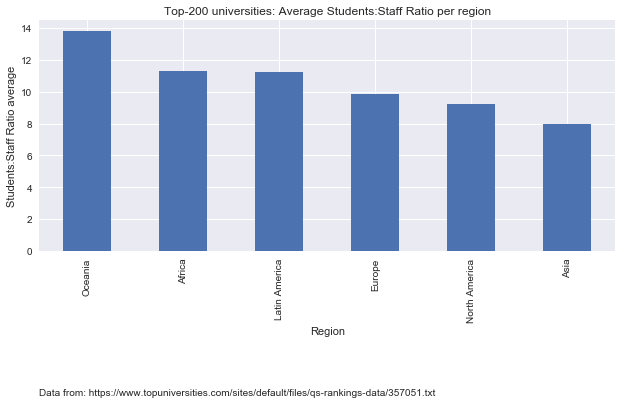

In [25]:
average_plot(dataQS, 'Students:Staff Ratio', 'region',
             'Top-200 universities: Average Students:Staff Ratio per region',
             'Region', 'Students:Staff Ratio average',
             url_QS)

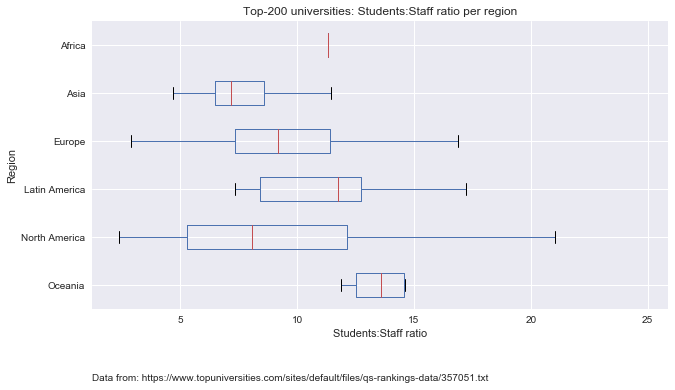

In [26]:
boxplot(dataQS, 'Students:Staff Ratio', 'region',
        'Top-200 universities: Students:Staff ratio per region',
        'Students:Staff ratio', 'Region',
        'horizontal', url_QS)

In [27]:
source = ColumnDataSource(data=dict(
    y=dataQS_tmp['region'],
    x=dataQS['Students:Staff Ratio'],
    title=dataQS['title'],
    region=dataQS['region'],
    ratio=dataQS['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: Students:Staff ratio per region', 'Students:Staff ratio', 'Region',
                    '', sorted_regions_QS,
                   'horizontal', url_QS)

Among the top-200 universities, it is in Europe, North America and Asia that the *Students:Staff Ratio* seems to be the lowest on average. At the same time, Europe and North America also display a larger variance: the top-3 universities with the highest *Students:Staff Ratio* are located in Europe, and the top-8 in Europe or North America. The universities with the highest *Students:Staff Ratio* however can be found in Europe as well.
On average, it is the top universities in Asia which have the lowest *Students:Staff Ratio*, with the majority of them being in Japan.

#### *Students international:Students Ratio* by region

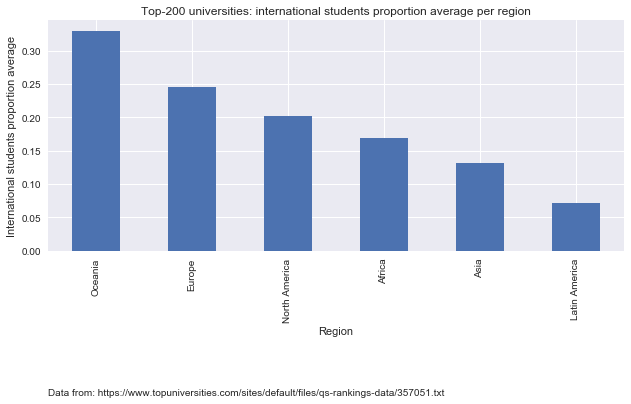

In [28]:
average_plot(dataQS, 'Students international:Students Ratio', 'region',
             'Top-200 universities: international students proportion average per region',
             'Region', 'International students proportion average', url_QS)

In [29]:
dataQS.groupby("region").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=False))

cc        country     nid rank_display         region  \
region                                                                     
Africa        190  ZA   South Africa  294558          191         Africa   
Asia          25   HK      Hong Kong  294256           26           Asia   
              48   HK      Hong Kong  294527           49           Asia   
              10   SG      Singapore  294821           11           Asia   
              29   HK      Hong Kong  294255           30           Asia   
              14   SG      Singapore  294798           15           Asia   
              45   HK      Hong Kong  294277           46           Asia   
              95   HK      Hong Kong  294257          =95           Asia   
              113  MY       Malaysia  294877         =114           Asia   
              37   CN          China  294606          =38           Asia   
              172  SA   Saudi Arabia  297053         =173           Asia   
              39   CN          China  294367           40           Asia   
              154  KR    South Korea  294273          155           Asia   
              89   KR    South Korea  294121          =90           Asia   
              105  KR    South Korea  297129          106           Asia   
              107  KR    South Korea  297467          108           Asia   
              86   CN          China  297123           87           Asia   
              24   CN          China  297235           25           Asia   
              55   JP          Japan  297248           56           Asia   
              76   TW         Taiwan  294804          =76           Asia   
              115  JP          Japan  294832         =116           Asia   
              27   JP          Japan  297246          =28           Asia   
              127  JP          Japan  294103          128           Asia   
              62   JP          Japan  297628           63           Asia   
              114  CN          China  294826         =114           Asia   
              75   JP          Japan  297250          =76           Asia   
              35   JP          Japan  294111          =36           Asia   
              161  TW         Taiwan  294800         =161           Asia   
              36   KR    South Korea  297403          =36           Asia   
              122  JP          Japan  294258         =122           Asia   
...                ..            ...     ...          ...            ...   
North America 149  US  United States  294858         =149  North America   
              85   US  United States  294741           86  North America   
              93   US  United States  297570          =93  North America   
              168  US  United States  294505          169  North America   
              139  CA         Canada  294863          140  North America   
              60   US  United States  297194           61  North America   
              117  US  United States  294571          118  North America   
              128  US  United States  294867          129  North America   
              54   US  United States  297183           55  North America   
              141  US  United States  297561         =142  North America   
              162  US  United States  294852          163  North America   
              177  US  United States  294394          178  North America   
              66   US  United States  297257           67  North America   
              133  US  United States  294565          134  North America   
              183  US  United States  294520         =182  North America   
              174  US  United States  297205         =173  North America   
              196  US  United States  297256         =195  North America   
              79   US  United States  294836           80  North America   
              51   US  United States  294786           52  North America   
Oceania       41   AU      Australia  294861          =41        Oc

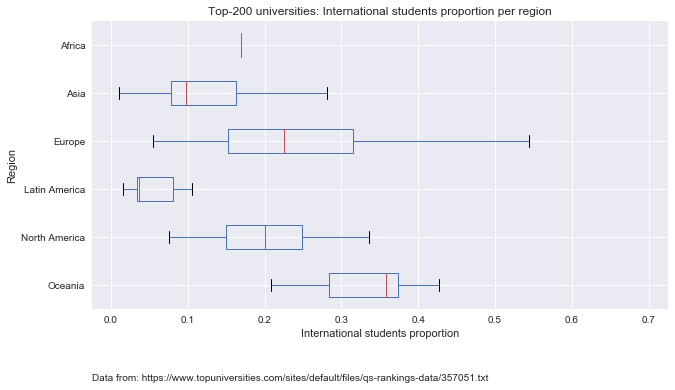

In [30]:
boxplot(dataQS, 'Students international:Students Ratio', 'region',
        'Top-200 universities: International students proportion per region',
        'International students proportion', 'Region',
        'horizontal', url_QS)

In [31]:
source = ColumnDataSource(data=dict(
    y=dataQS_tmp['region'],
    x=dataQS['Students international:Students Ratio'],
    title=dataQS['title'],
    region=dataQS['region'],
    ratio=dataQS['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('International students proportion', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: International students proportion per region', 'International students proportion', 'Region',
                   '', sorted_regions_QS,
                   'horizontal', url_QS)

We see that the top universities with an international students proportion higher than 50% are all located in Europe. 
North America displays a rather low variance around an average score of 20%, except for one university (the Carnegie Mellon University) which almost reaches the 50% too.

The top universities in Latin America have a rather low international students proportion compared to the other world regions.
On average, Oceania scores highest, with allthe top universities having an international students proportion greater than 20%. 
Still, there are only 10 universities which are listed in the QS ranking for Oceania; North America and Europe each have at least two dozen of them.

### Ratio of faculty members and international students (by country)

#### *Students:Staff Ratio* by country

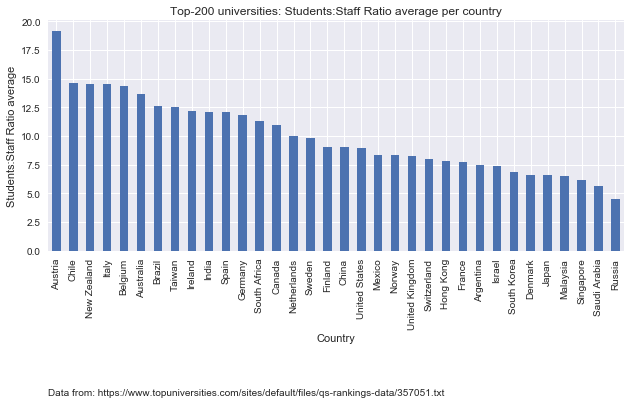

In [32]:
average_plot(dataQS, 'Students:Staff Ratio', 'country',
             'Top-200 universities: Students:Staff Ratio average per country',
             'Country', 'Students:Staff Ratio average', url_QS)

In [33]:
dataQS.groupby("country").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

cc        country     nid rank_display         region  \
country                                                                    
Argentina     74   AR      Argentina  294578           75  Latin America   
Australia     19   AU      Australia  294616           20        Oceania   
              46   AU      Australia  297460          =47        Oceania   
              110  AU      Australia  294644         =109        Oceania   
              41   AU      Australia  294861          =41        Oceania   
              92   AU      Australia  297188          =93        Oceania   
              44   AU      Australia  294788           45        Oceania   
              49   AU      Australia  296815           50        Oceania   
              59   AU      Australia  294848           60        Oceania   
              175  AU      Australia  297273          176        Oceania   
Austria       153  AT        Austria  297209          154         Europe   
              184  AT        Austria  297208         =182         Europe   
Belgium       181  BE        Belgium  294582         =182         Europe   
              125  BE        Belgium  294329         =125         Europe   
              71   BE        Belgium  294551          =71         Europe   
              152  BE        Belgium  294550          153         Europe   
Brazil        120  BR         Brazil  297422          121  Latin America   
              182  BR         Brazil  294560         =182  Latin America   
Canada        139  CA         Canada  294863          140  North America   
              30   CA         Canada  297242           31  North America   
              31   CA         Canada  294864           32  North America   
              90   CA         Canada  294639          =90  North America   
              50   CA         Canada  294586           51  North America   
              129  CA         Canada  294843          130  North America   
              151  CA         Canada  297191          152  North America   
Chile         137  CL          Chile  294549         =137  Latin America   
              199  CL          Chile  294535          201  Latin America   
China         24   CN          China  297235           25           Asia   
              39   CN          China  294367           40           Asia   
              96   CN          China  294534           97           Asia   
...                ..            ...     ...          ...            ...   
United States 168  US  United States  294505          169  North America   
              54   US  United States  297183           55  North America   
              88   US  United States  297437           89  North America   
              52   US  United States  294584           53  North America   
              85   US  United States  294741           86  North America   
              12   US  United States  297490           13  North America   
              13   US  United States  294514           14  North America   
              80   US  United States  294593           81  North America   
              183  US  United States  294520         =182  North America   
              177  US  United States  294394          178  North America   
              174  US  United States  297205         =173  North America   
              38   US  United States  294567          =38  North America   
              117  US  United States  294571          118  North America   
              128  US  United States  294867          129  North America   
              47   US  United States  294555          =47  North America   
              26   US  United States  294572           27  North America   
              104  US  United States  297485          105  North America   
              162  US  United States  294852          163  North America   
              131  US  United States  297286          132  North America   
              93   US  United States  297570          =93  North Am

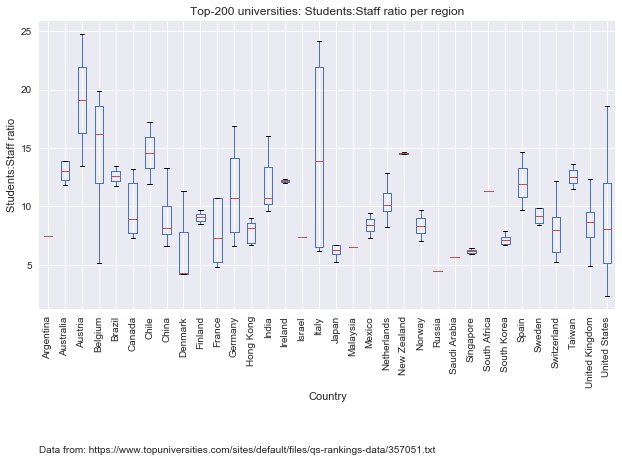

In [34]:
boxplot(dataQS, 'Students:Staff Ratio', 'country',
        'Top-200 universities: Students:Staff ratio per region',
        'Country', 'Students:Staff ratio',
        'vertical', url_QS)

In [35]:
source = ColumnDataSource(data=dict(
    x=dataQS_tmp['country'],
    y=dataQS['Students:Staff Ratio'],
    title=dataQS['title'],
    country=dataQS['country'],
    ratio=dataQS['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: Students:Staff ratio per country', 'Country', 'Students:Staff ratio',
                   sorted_countries_QS, '',
                   'vertical', url_QS)

As pointed out previously, the top universities with the highest international students proportion are mostly in Europe and North America, with a score close to 4 or less.
In comparison, among the top-200 universities of the QS ranking, the highest *Students:Staff Ratio*, in the Vienna University of Technology, is almost 25.

#### *Students international:Students Ratio* by country (QS ranking)

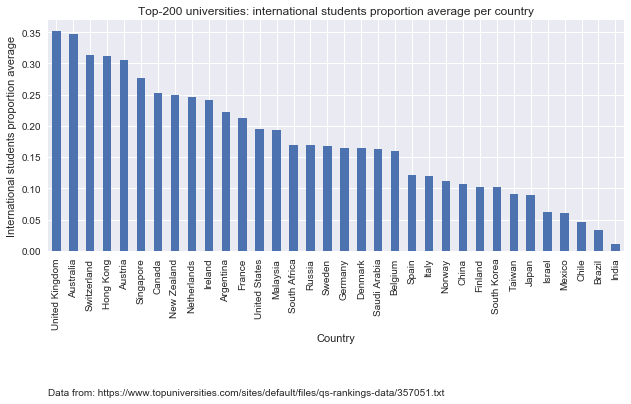

In [36]:
average_plot(dataQS, 'Students international:Students Ratio', 'country',
             'Top-200 universities: international students proportion average per country',
             'Country', 'International students proportion average', url_QS)

In [37]:
dataQS.groupby("country").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=False))

cc        country     nid rank_display         region  \
country                                                                    
Argentina     74   AR      Argentina  294578           75  Latin America   
Australia     41   AU      Australia  294861          =41        Oceania   
              19   AU      Australia  294616           20        Oceania   
              110  AU      Australia  294644         =109        Oceania   
              49   AU      Australia  296815           50        Oceania   
              44   AU      Australia  294788           45        Oceania   
              59   AU      Australia  294848           60        Oceania   
              175  AU      Australia  297273          176        Oceania   
              46   AU      Australia  297460          =47        Oceania   
              92   AU      Australia  297188          =93        Oceania   
Austria       153  AT        Austria  297209          154         Europe   
              184  AT        Austria  297208         =182         Europe   
Belgium       181  BE        Belgium  294582         =182         Europe   
              152  BE        Belgium  294550          153         Europe   
              71   BE        Belgium  294551          =71         Europe   
              125  BE        Belgium  294329         =125         Europe   
Brazil        182  BR         Brazil  294560         =182  Latin America   
              120  BR         Brazil  297422          121  Latin America   
Canada        31   CA         Canada  294864           32  North America   
              30   CA         Canada  297242           31  North America   
              90   CA         Canada  294639          =90  North America   
              151  CA         Canada  297191          152  North America   
              129  CA         Canada  294843          130  North America   
              50   CA         Canada  294586           51  North America   
              139  CA         Canada  294863          140  North America   
Chile         199  CL          Chile  294535          201  Latin America   
              137  CL          Chile  294549         =137  Latin America   
China         37   CN          China  294606          =38           Asia   
              39   CN          China  294367           40           Asia   
              86   CN          China  297123           87           Asia   
...                ..            ...     ...          ...            ...   
United States 12   US  United States  297490           13  North America   
              38   US  United States  294567          =38  North America   
              18   US  United States  297569           19  North America   
              99   US  United States  297193          100  North America   
              15   US  United States  297177           16  North America   
              52   US  United States  294584           53  North America   
              21   US  United States  294490          =21  North America   
              28   US  United States  294767          =28  North America   
              20   US  United States  294857          =21  North America   
              32   US  United States  294569           33  North America   
              147  US  United States  294471         =147  North America   
              26   US  United States  294572           27  North America   
              149  US  United States  294858         =149  North America   
              85   US  United States  294741           86  North America   
              93   US  United States  297570          =93  North America   
              168  US  United States  294505          169  North America   
              60   US  United States  297194           61  North America   
              117  US  United States  294571          118  North America   
              128  US  United States  294867          129  North America   
              54   US  United States  297183           55  North Am

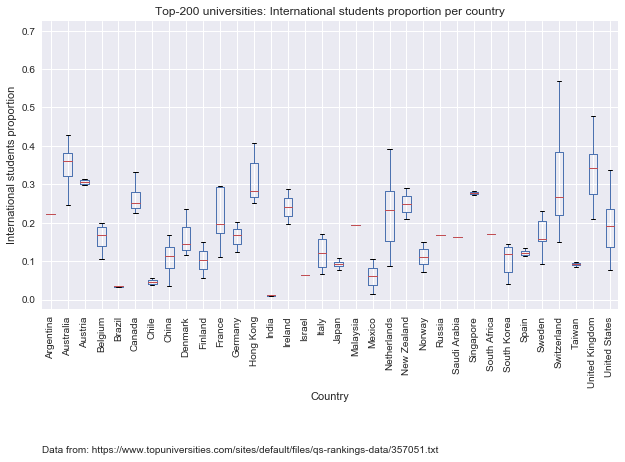

In [38]:
boxplot(dataQS, 'Students international:Students Ratio', 'country',
       'Top-200 universities: International students proportion per country',
        'Country', 'International students proportion',
        'vertical', url_QS)

In [39]:
source = ColumnDataSource(data=dict(
    x=dataQS_tmp['country'],
    y=dataQS['Students international:Students Ratio'],
    title=dataQS['title'],
    country=dataQS['country'],
    ratio=dataQS['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('International students proportion', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: International students proportion per country', 'Country', 'International students proportion',
                   sorted_countries_QS, '',
                   'vertical', url_QS)

The top-2 countries with the highest average international students proportion are the United Kingdom and Australia. 
Among the top-10, one can also find Hong Kong, Singapore or Canada: english-speaking countries seem to be a popular destination for international students.

The 3 universities with the lowest *Students international:Students Ratio* are in India, with a proportion of barely 1% or less of international students.

## Conclusion

Most of the top universities listed by the QS ranking are located in Europe and North America, and are either in the United Kingdom or in the United States.
Therefore, it may be sometimes difficult to draw a conclusion which is representative of the whole region.

It is difficult as well to compare the *Students:Staff Ratio* and *Students international:Students Ratio* of the top universities in Africa, because the QS ranking listed only a single one.


# Times Higher Education University Ranking
### www.timeshighereducation.com

Same schema go to : "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

And we have the data at json format

In [121]:
url_THE = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

r =  requests.get(url_THE)
print(r.status_code)
import json
from io import StringIO
json = json.load(StringIO(r.text))
dataTHE = pd.DataFrame(json['data'])

200


In [122]:
dataTHE.head()

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


We drop the columns which are not relevant for us.

In [123]:
dataTHE.drop("record_type",axis=1,inplace=True)
dataTHE.drop("aliases",axis=1,inplace=True)
dataTHE.drop("subjects_offered",axis=1,inplace=True)
dataTHE.drop("scores_teaching_rank",axis=1,inplace=True)
dataTHE.drop("scores_citations",axis=1,inplace=True)
dataTHE.drop("scores_industry_income",axis=1,inplace=True)
dataTHE.drop("scores_citations_rank",axis=1,inplace=True)
dataTHE.drop("scores_industry_income_rank",axis=1,inplace=True)
dataTHE.drop("scores_international_outlook",axis=1,inplace=True)
dataTHE.drop("scores_research",axis=1,inplace=True)
dataTHE.drop("scores_teaching",axis=1,inplace=True)
dataTHE.drop("scores_research_rank",axis=1,inplace=True)
dataTHE.drop("scores_international_outlook_rank",axis=1,inplace=True)

dataTHE.head()

,location,member_level,name,nid,rank,rank_order,scores_overall,scores_overall_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,url
0,United Kingdom,0,University of Oxford,468,1,10,94.3,10,46 : 54,"20,409",38%,11.2,/world-university-rankings/university-oxford
1,United Kingdom,0,University of Cambridge,470,2,20,93.2,20,45 : 55,"18,389",35%,10.9,/world-university-rankings/university-cambridge
2,United States,0,California Institute of Technology,128779,=3,30,93.0,30,31 : 69,"2,209",27%,6.5,/world-university-rankings/california-institut...
3,United States,11,Stanford University,467,=3,40,93.0,40,42 : 58,"15,845",22%,7.5,/world-university-rankings/stanford-university
4,United States,0,Massachusetts Institute of Technology,471,5,50,92.5,50,37 : 63,"11,177",34%,8.7,/world-university-rankings/massachusetts-insti...


For convenience, we rename the *name*, *location*, *stats_student_staff_ratio* and *stats_pc_intl_students* columns into *title*, *country*, *Students:Staff Ratio* and *Students international:Students Ratio* respectively, so that they match the corresponding columns in the QS ranking data.

In [124]:
dataTHE.rename(columns={'stats_student_staff_ratio':'Students:Staff Ratio'}, inplace=True)
dataTHE.rename(columns={'stats_pc_intl_students':'Students international:Students Ratio'}, inplace=True)
dataTHE.rename(columns={'name':'title'}, inplace=True)
dataTHE.rename(columns={'location':'country'}, inplace=True)

For the subsequent analysis, we only keep the top-200 universities according to the THE ranking.

In [125]:
dataTHE = dataTHE.head(200)

The *Students international:Students Ratio* value is currently a percentage, stored as an *Object*. We therefore transform it into a numerical value, so that its manipulation becomes more convenient.
For the same reason, we convert the *Students:Staff Ratio* into a numerical value as well.

In [126]:
dataTHE['Students international:Students Ratio'] = dataTHE['Students international:Students Ratio'].apply(lambda x: int(x.split('%')[0]) / 100)
dataTHE['Students:Staff Ratio'] = pd.to_numeric(dataTHE['Students:Staff Ratio'])

Complete list of the top-200 universites according to the *Times Higher Education* ranking

In [127]:
dataTHE

,country,member_level,title,nid,rank,rank_order,scores_overall,scores_overall_rank,stats_female_male_ratio,stats_number_students,Students international:Students Ratio,Students:Staff Ratio,url
0,United Kingdom,0,University of Oxford,468,1,10,94.3,10,46 : 54,"20,409",0.38,11.2,/world-university-rankings/university-oxford
1,United Kingdom,0,University of Cambridge,470,2,20,93.2,20,45 : 55,"18,389",0.35,10.9,/world-university-rankings/university-cambridge
2,United States,0,California Institute of Technology,128779,=3,30,93.0,30,31 : 69,"2,209",0.27,6.5,/world-university-rankings/california-institut...
3,United States,11,Stanford University,467,=3,40,93.0,40,42 : 58,"15,845",0.22,7.5,/world-university-rankings/stanford-university
4,United States,0,Massachusetts Institute of Technology,471,5,50,92.5,50,37 : 63,"11,177",0.34,8.7,/world-university-rankings/massachusetts-insti...
5,United States,0,Harvard University,466,6,60,91.8,60,None,"20,326",0.26,8.9,/world-university-rankings/harvard-university
6,United States,0,Princeton University,469,7,70,91.1,70,45 : 55,"7,955",0.24,8.3,/world-university-rankings/princeton-university
7,United Kingdom,0,Imperial College London,472,8,80,89.2,80,37 : 63,"15,857",0.55,11.4,/world-university-rankings/imperial-college-lo...
8,United States,0,University of Chicago,473,9,90,88.6,90,44 : 56,"13,525",0.25,6.2,/world-university-rankings/university-chicago
9,Switzerland,0,ETH Zurich – Swiss Federal Institute of Techno...,479,=10,100,87.7,100,31 : 69,"19,233",0.38,14.6,/world-university-rankings/eth-zurich-swiss-fe...


### Ratio of faculty members and international students (worldwide)

Like for the QS ranking, for readability, we only display the top-60 universities.

As before, the *Students:Staff Ratio* is sorted in increasing order (a high number of staff per student is perceived as providing higher quality education).

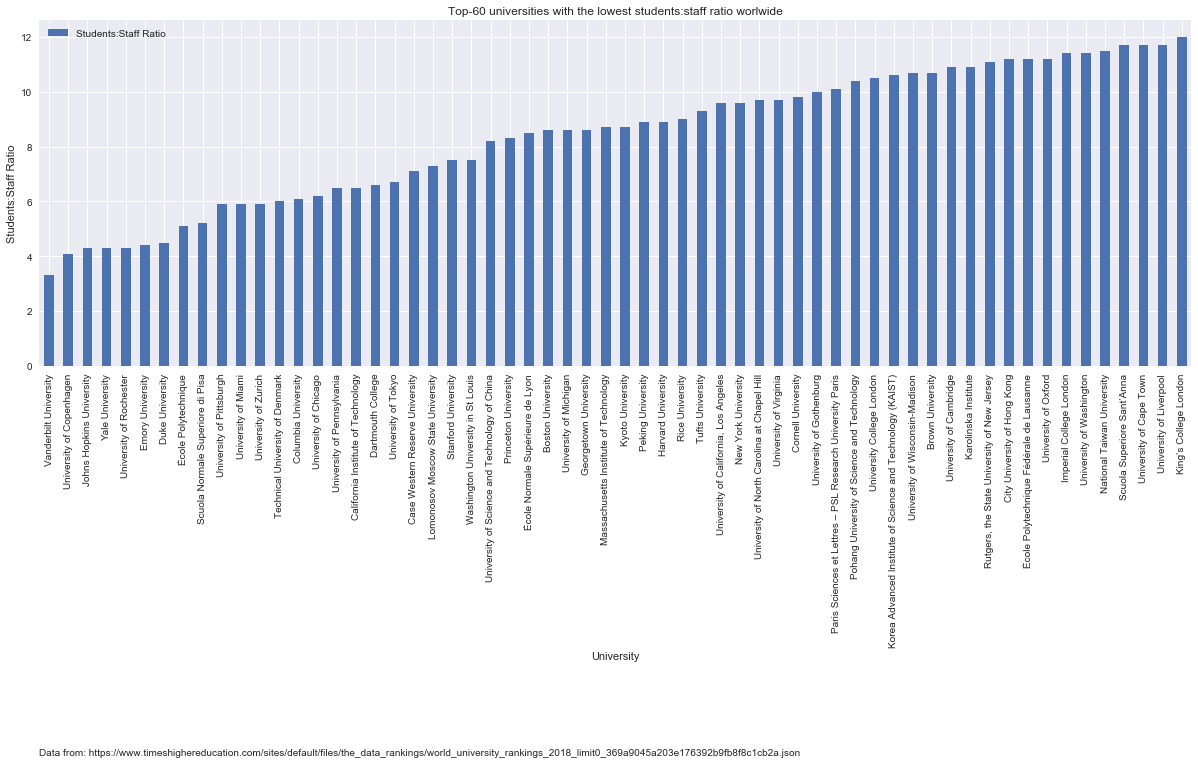

In [128]:
top = 60
plot_top_n(dataTHE, 'Students:Staff Ratio', top, True, 
         'Top-' + str(top) + ' universities with the lowest students:staff ratio worlwide',
         'University', 'Students:Staff Ratio', url_THE)

Again, the *Students international:Students Ratio* is sorted in decreasing order: a high proportion of international students is perceived as providing a higher interculturality in a university.

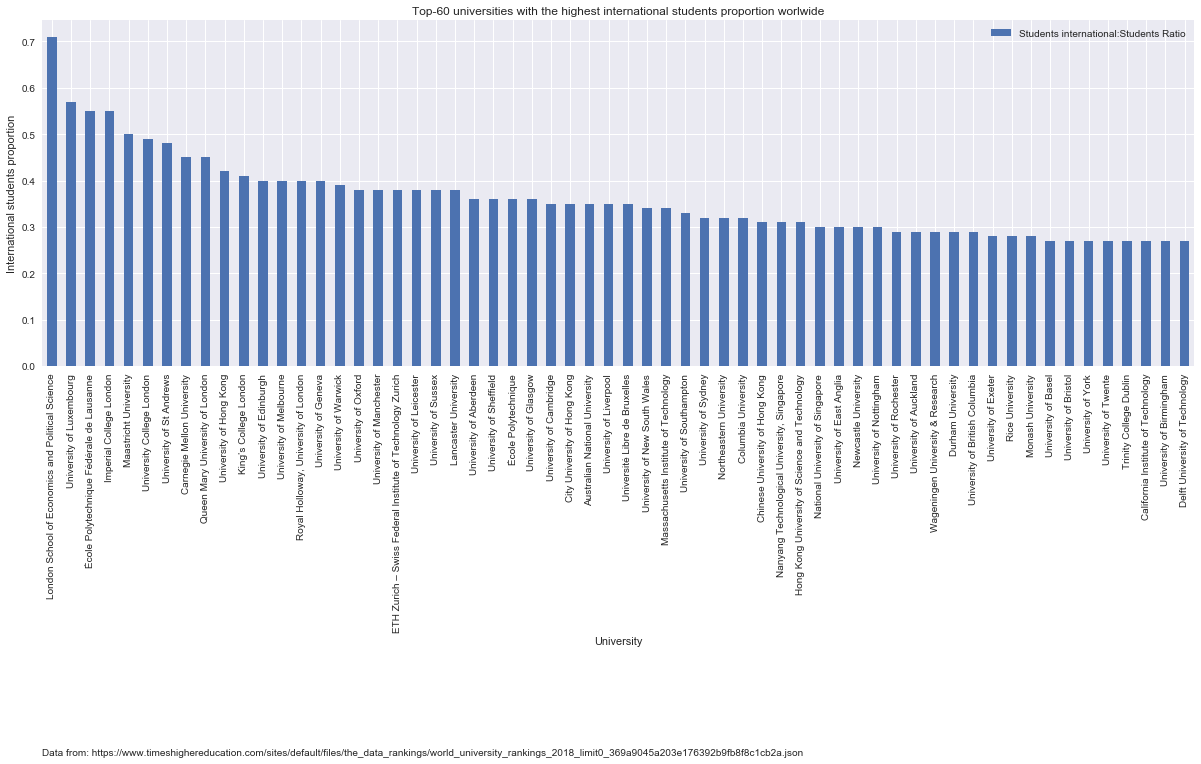

In [129]:
top = 60
plot_top_n(dataTHE, 'Students international:Students Ratio', top, False, 
         'Top-' + str(top) + ' universities with the highest international students proportion worlwide',
         'University', 'International students proportion', url_THE)

Interestingly, for the top-10 universities with the lowest *Students:Staff Ratio*, the two rankings only have three universities in common (the Yale University (USA), the University of Rochester (USA) and the Ecole Polytechnique (France)).

The results for the international students proportion are more consistent: 9 universities out of 10 are found in the both top-10s. In the QS ranking, the University of Melbourne ranks at position 8, but only 13 in the THE ranking. The University of Luxembourg, which ranks second in the THE ranking, happens to not appear in the top-200 universities of the QS ranking though.

### Ratio of faculty members and international students (by region)

We repeat the lexicographical sorting and mapping to to a numerical range for the *region* and *country* columns of the data from Times Higher Education.
The ranking in Times Higher Education however lacks a *region* field. We use the same country to region mapping as for the QS ranking.

In [130]:
country_region_pairs = dataQS[['country', 'region']].drop_duplicates()
country_to_region = {country:region for (country, region) in zip(country_region_pairs['country'],country_region_pairs['region'])}

Among the countries where the top-200 universities are found, one of them - Luxembourg - does not appear in the QS ranking though. We therefore manualy map it in the dictionary.

In [131]:
only_THE_countries = dataTHE['country'][~(dataTHE['country'].isin(dataQS['country']))]
print(only_THE_countries)

178            Luxembourg
193    Russian Federation
Name: country, dtype: object


In [132]:
country_to_region['Luxembourg'] = 'Europe'

As for the 'Russian Federation', we replace it with 'Russia', so that the country names match for both rankings.

In [133]:
dataTHE.replace('Russian Federation', 'Russia', inplace=True)

We then add the new *region* column to the original dataframe using the previously created mapping.

In [134]:
dataTHE['region'] = dataTHE['country'].map(country_to_region)

The THE ranking does not list universities from 'Latin America':

In [176]:
dataTHE['region'].unique()

array(['Europe', 'North America', 'Asia', 'Oceania', 'Africa'], dtype=object)

In [135]:
dataTHE_tmp = dataTHE.copy()

In [136]:
sorted_regions_THE = sorted(dataTHE['region'].unique(), reverse=True)
mapping = {i:sorted_regions_THE.index(i) for i in sorted_regions_THE}
dataTHE_tmp['region'] = dataTHE['region'].map(mapping)

In [137]:
sorted_countries_THE = sorted(dataTHE['country'].unique(), reverse=False)
mapping = {i:sorted_countries_THE.index(i) for i in sorted_countries_THE}
dataTHE_tmp['country'] = dataTHE['country'].map(mapping)

#### *Students:Staff Ratio* by region

Complete list of the top-200 universities, sorted by region and by *Students:Staff Ratio*

In [138]:
dataTHE.groupby("region").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

country member_level  \
region                                          
Africa        170   South Africa            0   
Asia          45           Japan            0   
              131          China            0   
              73           Japan            0   
              28           China            0   
              136    South Korea            6   
              95     South Korea            6   
              119      Hong Kong           11   
              199         Taiwan            0   
              115          China            0   
              188          China            0   
              74     South Korea            0   
              29           China            6   
              177          China           11   
              168          China            0   
              51       Singapore            6   
              21       Singapore            6   
              57       Hong Kong           11   
              39       Hong Kong           11   
              110    South Korea            6   
              43       Hong Kong           11   
              182      Hong Kong           11   
Europe        109        Denmark            0   
              114         France            1   
              183          Italy            0   
              135    Switzerland            0   
              152        Denmark            0   
              193         Russia            0   
              181         France            0   
              198         Sweden            0   
...                          ...          ...   
North America 167  United States            0   
              100  United States            0   
              68   United States            0   
              83   United States            0   
              98   United States            0   
              48   United States            0   
              59   United States            0   
              55   United States            0   
              142  United States            0   
              33          Canada            0   
              22          Canada            0   
              125  United States            0   
              32   United States            0   
              197  United States            0   
              118         Canada            0   
              107         Canada            0   
              36   United States            0   
              161  United States            0   
              159  United States            0   
              77          Canada           11   
              52   United States            0   
Oceania       191    New Zealand           11   
              47       Australia            6   
              60       Australia           11   
              111      Australia           11   
              31       Australia           11   
              84       Australia           11   
              80       Australia            0   
              133      Australia            6   
              64       Australia            0   

                                                               title     nid  \
region                                                                         
Africa        170                            University of Cape Town     567   
Asia          45                                 University of Tokyo     494   
              131      University of Science and Technology of China     656   
              73                                    Kyoto University     516   
              28                                   Peking University     514   
              136        Pohang University of Science and Technology     517   
              95   Korea Advanced Institute of Science and Techno...     558   
              119                       City University of Hong Kong     657   
              199                         National Taiwan University     618   
              115                                   Fudan

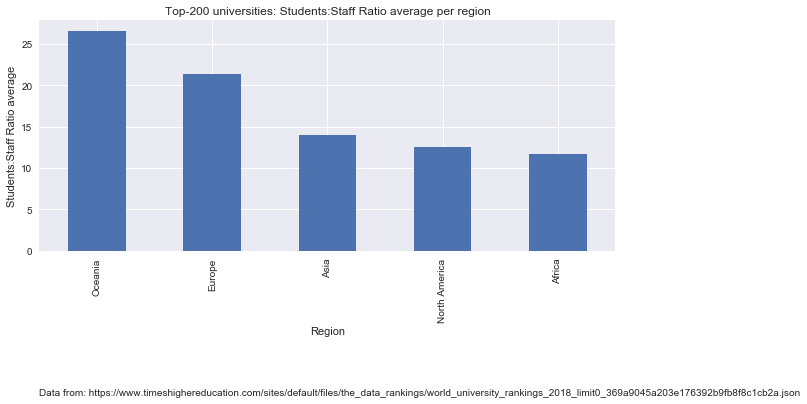

In [139]:
average_plot(dataTHE, 'Students:Staff Ratio', 'region',
             'Top-200 universities: Students:Staff Ratio average per region', 
             'Region', 'Students:Staff Ratio average', url_THE)

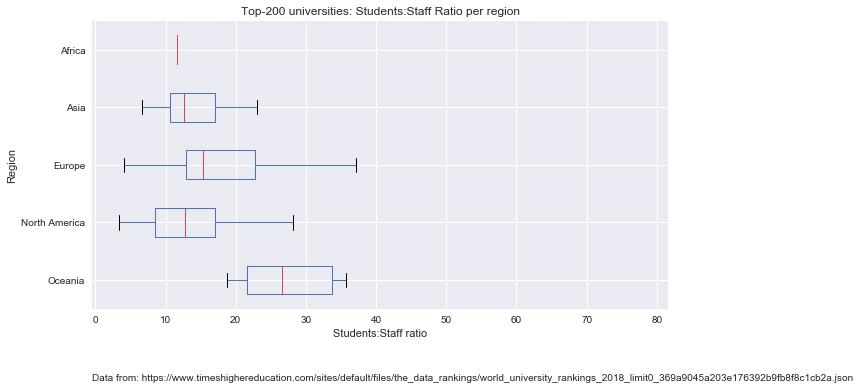

In [183]:
boxplot(dataTHE, 'Students:Staff Ratio', 'region',
        'Top-200 universities: Students:Staff Ratio per region', 'Students:Staff ratio', 'Region',
        'horizontal', url_THE)

In [141]:
source = ColumnDataSource(data=dict(
    y=dataTHE_tmp['region'],
    x=dataTHE['Students:Staff Ratio'],
    title=dataTHE['title'],
    region=dataTHE['region'],
    ratio=dataTHE['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Students:Staff ratio per region', 'Students:Staff atio', 'Region',
                    '', sorted_regions_THE,
                   'horizontal', url_THE)

In the THE ranking, the values for the *Students:Satff Ratio* are much more spread out compared to the QS ranking, particularly regarding the universities in Europe: the QS ranking indicates a *Students:Staff Ratio* of roughly 24 for the Freie Universität Berlin, but the THE ranking a value of 57, which is more than twice as much.

#### *Students international:Students Ratio* by region

Complete list of the top-200 universities, sorted by region and by *Students:Staff Ratio*

In [142]:
dataTHE.groupby("region").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=True))

country member_level  \
region                                          
Africa        170   South Africa            0   
Asia          131          China            0   
              136    South Korea            6   
              177          China           11   
              188          China            0   
              199         Taiwan            0   
              73           Japan            0   
              95     South Korea            6   
              29           China            6   
              45           Japan            0   
              115          China            0   
              168          China            0   
              74     South Korea            0   
              110    South Korea            6   
              28           China            0   
              182      Hong Kong           11   
              21       Singapore            6   
              57       Hong Kong           11   
              43       Hong Kong           11   
              51       Singapore            6   
              119      Hong Kong           11   
              39       Hong Kong           11   
Europe        89         Finland           11   
              67     Netherlands            1   
              183          Italy            0   
              165    Netherlands            0   
              173        Germany            0   
              134         Sweden            0   
              166        Germany            0   
              144        Germany            0   
...                          ...          ...   
North America 59   United States            0   
              65   United States            0   
              36   United States            0   
              6    United States            0   
              12   United States            0   
              18   United States            0   
              69   United States            0   
              8    United States            0   
              5    United States            0   
              27   United States            0   
              41          Canada            0   
              118         Canada            0   
              32   United States            0   
              2    United States            0   
              85   United States            0   
              33          Canada            0   
              153  United States            0   
              13   United States            0   
              192  United States            0   
              4    United States            0   
              23   United States            0   
Oceania       111      Australia           11   
              64       Australia            0   
              133      Australia            6   
              80       Australia            0   
              191    New Zealand           11   
              60       Australia           11   
              84       Australia           11   
              47       Australia            6   
              31       Australia           11   

                                                               title     nid  \
region                                                                         
Africa        170                            University of Cape Town     567   
Asia          131      University of Science and Technology of China     656   
              136        Pohang University of Science and Technology     517   
              177                                Zhejiang University     815   
              188                      Shanghai Jiao Tong University     801   
              199                         National Taiwan University     618   
              73                                    Kyoto University     516   
              95   Korea Advanced Institute of Science and Techno...     558   
              29                                 Tsinghua University     535   
              45                                 Universi

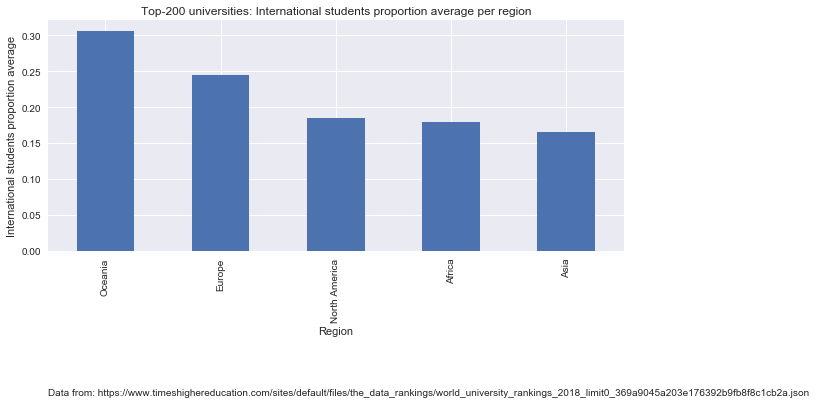

In [143]:
average_plot(dataTHE, 'Students international:Students Ratio', 'region',
             'Top-200 universities: International students proportion average per region', 
             'Region', 'International students proportion average', url_THE)

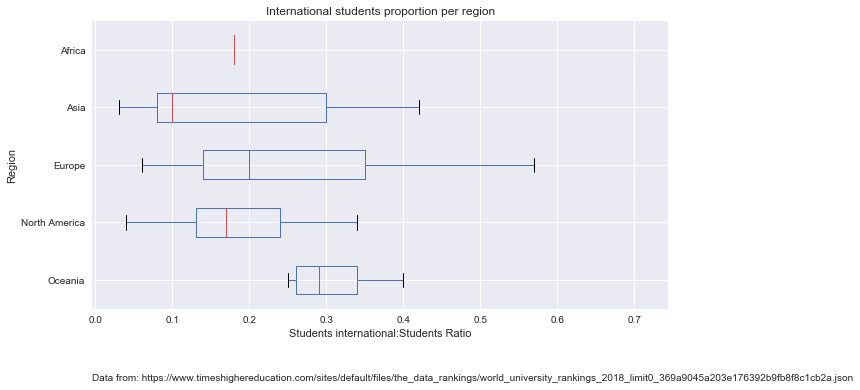

In [144]:
boxplot(dataTHE, 'Students international:Students Ratio', 'region',
        'International students proportion per region', 'Students international:Students Ratio', 'Region',
        'horizontal', url_THE)

In [145]:
source = ColumnDataSource(data=dict(
    y=dataTHE_tmp['region'],
    x=dataTHE_tmp['Students international:Students Ratio'],
    title=dataTHE['title'],
    region=dataTHE['region'],
    ratio=dataTHE['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Students international:Students Ratio per region', 'Students international:Students Ratio', 'Region',
                    '', sorted_regions_THE,
                   'horizontal', url_THE)

For the international students proportion per region, except for the fact that no university represents Lain America in the THE ranking, the two rankings are consistent.

#### *Students:Staff Ratio* by country

Complete list of the top-200 universities, sorted by country and by *Students:Staff Ratio*

In [146]:
dataTHE.groupby("country").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

country member_level  \
country                                         
Australia     47       Australia            6   
              60       Australia           11   
              111      Australia           11   
              31       Australia           11   
              84       Australia           11   
              80       Australia            0   
              133      Australia            6   
              64       Australia            0   
Austria       164        Austria            0   
Belgium       106        Belgium            0   
              46         Belgium            1   
              128        Belgium            0   
              174        Belgium            0   
Canada        41          Canada            0   
              33          Canada            0   
              22          Canada            0   
              118         Canada            0   
              107         Canada            0   
              77          Canada           11   
China         131          China            0   
              28           China            0   
              115          China            0   
              188          China            0   
              29           China            6   
              177          China           11   
              168          China            0   
Denmark       109        Denmark            0   
              152        Denmark            0   
              108        Denmark            0   
Finland       89         Finland           11   
...                          ...          ...   
United States 25   United States            0   
              70   United States            0   
              19   United States            0   
              65   United States            0   
              30   United States            0   
              160  United States            0   
              17   United States            0   
              190  United States            0   
              150  United States            0   
              23   United States            0   
              53   United States            0   
              192  United States            0   
              116  United States            0   
              167  United States            0   
              76   United States            0   
              100  United States            0   
              68   United States            0   
              98   United States            0   
              83   United States            0   
              48   United States            0   
              59   United States            0   
              55   United States            0   
              142  United States            0   
              125  United States            0   
              32   United States            0   
              197  United States            0   
              36   United States            0   
              161  United States            0   
              159  United States            0   
              52   United States            0   

                                                           title     nid  \
country                                                                    
Australia     47                  Australian National University     502   
              60                            University of Sydney     522   
              111                University of Western Australia     654   
              31                         University of Melbourne     501   
              84                   University of New South Wales     638   
              80                               Monash University     581   
              133                         University of Adelaide     665   
              64                        University of Queensland     538   
Austria       164                           University of Vienna     603   
Belgium       106                               Ghent University     570   
              46         

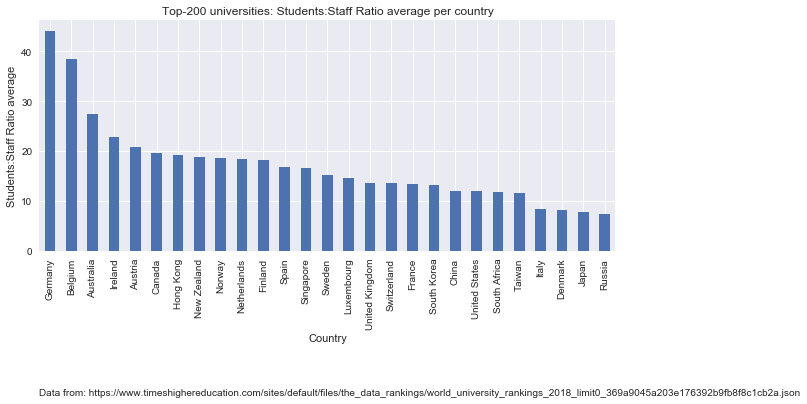

In [147]:
average_plot(dataTHE, 'Students:Staff Ratio', 'country',
             'Top-200 universities: Students:Staff Ratio average per country',
             'Country', 'Students:Staff Ratio average', url_THE)

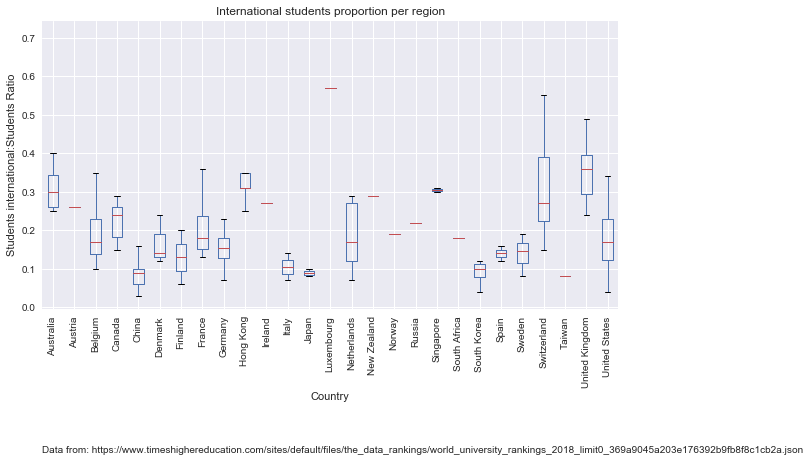

In [148]:
boxplot(dataTHE, 'Students international:Students Ratio', 'country',
        'International students proportion per region', 'Country', 'Students international:Students Ratio',
        'vertical', url_THE)

In [149]:
source = ColumnDataSource(data=dict(
    x=dataTHE_tmp['country'],
    y=dataTHE['Students:Staff Ratio'],
    title=dataTHE['title'],
    country=dataTHE['country'],
    ratio=dataTHE['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Students:Staff ratio per country', 'Country', 'Students:Staff ratio',
                    sorted_countries_THE, '',
                   'vertical', url_THE)

For some countries like Italy or Germany, the way the *Students:Staff Ratio* values are spread out differs quite a bit between the two rankings. This is also due to the fact that they did not select the same top-200 universities: the universities which are found in one ranking and not the other are often rather low ranked among the top-200.

#### *Students international:Students Ratio* by country

Complete list of the top-200 universities, sorted by countru and by *Students international:Students Ratio*

In [150]:
dataTHE.groupby("country").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=True))

country member_level  \
country                                         
Australia     111      Australia           11   
              64       Australia            0   
              133      Australia            6   
              80       Australia            0   
              60       Australia           11   
              84       Australia           11   
              47       Australia            6   
              31       Australia           11   
Austria       164        Austria            0   
Belgium       106        Belgium            0   
              46         Belgium            1   
              128        Belgium            0   
              174        Belgium            0   
Canada        77          Canada           11   
              22          Canada            0   
              107         Canada            0   
              41          Canada            0   
              118         Canada            0   
              33          Canada            0   
China         131          China            0   
              177          China           11   
              188          China            0   
              29           China            6   
              115          China            0   
              168          China            0   
              28           China            0   
Denmark       108        Denmark            0   
              109        Denmark            0   
              152        Denmark            0   
Finland       89         Finland           11   
...                          ...          ...   
United States 83   United States            0   
              122  United States            0   
              19   United States            0   
              97   United States            0   
              157  United States            0   
              125  United States            0   
              49   United States           11   
              10   United States            0   
              11   United States            0   
              98   United States            0   
              16   United States            0   
              3    United States           11   
              59   United States            0   
              65   United States            0   
              36   United States            0   
              18   United States            0   
              6    United States            0   
              12   United States            0   
              8    United States            0   
              69   United States            0   
              5    United States            0   
              27   United States            0   
              32   United States            0   
              2    United States            0   
              85   United States            0   
              153  United States            0   
              13   United States            0   
              192  United States            0   
              4    United States            0   
              23   United States            0   

                                                           title     nid  \
country                                                                    
Australia     111                University of Western Australia     654   
              64                        University of Queensland     538   
              133                         University of Adelaide     665   
              80                               Monash University     581   
              60                            University of Sydney     522   
              84                   University of New South Wales     638   
              47                  Australian National University     502   
              31                         University of Melbourne     501   
Austria       164                           University of Vienna     603   
Belgium       106                               Ghent University     570   
              46         

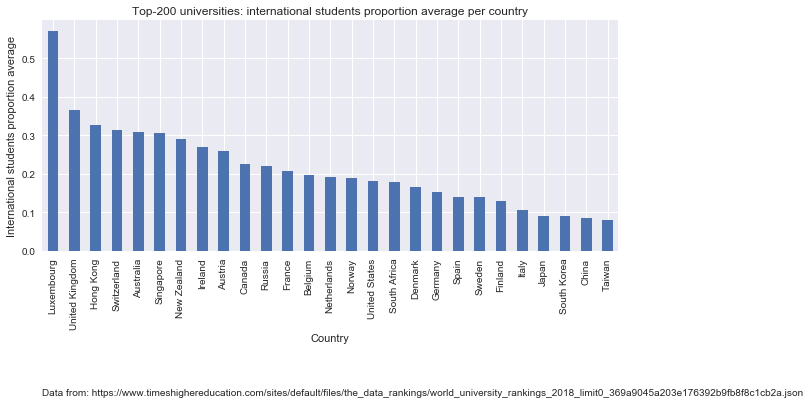

In [151]:
average_plot(dataTHE, 'Students international:Students Ratio', 'country',
             'Top-200 universities: international students proportion average per country',
             'Country', 'International students proportion average', url_THE)

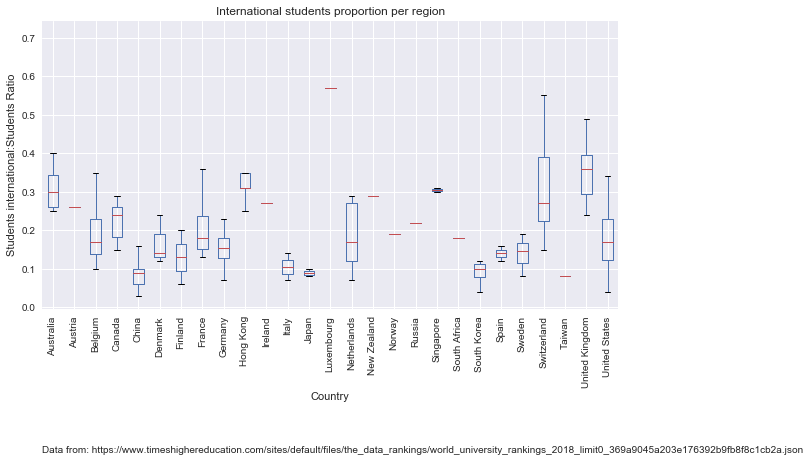

In [152]:
boxplot(dataTHE, 'Students international:Students Ratio', 'country',
        'International students proportion per region', 'Country', 'Students international:Students Ratio',
        'vertical', url_THE)

In [153]:
source = ColumnDataSource(data=dict(
    x=dataTHE_tmp['country'],
    y=dataTHE['Students international:Students Ratio'],
    title=dataTHE['title'],
    country=dataTHE['country'],
    ratio=dataTHE['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('International students proportion', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'International students proportion per country', 'Country', 'International students proportion',
                    sorted_countries_THE, '',
                   'vertical', url_THE)

As for the worldwide and by region cases, the results here are consistent with the QS ranking too. 
If we look at Switzerland, United Kingdom or United States for instance, where the same top universities tend to appear in both rankings, we see that the overall distribution, as well as the individual values per university, are very similar.

Conclusion
======


In general, regarding the number of international students, the two rankings seem in adequation. On the number of staff however, the two rankings do not haven the same ranking, they do not seem to count faculty memebers the same way.

# Merging the QS and the THE rankings

For merging, we will merge on *title* and *country*. The only problem is that in one ranking the university name is in english and in the other one the name is in the university's origin country (e.g. french, spanish ...)

So we will use an algorithm of fuzzy token, we choose fuzz.token_sort_ratio, it works on sentences like "Université de Machin". Moreover we translate some terms for a better efficiency:

Univedrsité -> University

Universitat -> University

We choose a threshold of 82 after some trying.


In [154]:
from fuzzywuzzy import fuzz

In [155]:
def get_closest_match(x, list_strings):
    """return for one x the best university which matches with the token_sort_ratio algorithm distance"""
    best_match = x
    highest_jw = 0

    for current_string in list_strings:
        current_score = fuzz.token_sort_ratio(x, current_string)
        # for each univertisy calculate the matching score

        # use a minimal threshold and same country to be sure we have exactly the same university
        if(current_score > highest_jw and  current_score>84): # thresold and country match
            if(dataTHEcpy.loc[dataTHEcpy.title_THE==current_string].country.iloc[0] == dataQScpy.loc[dataQScpy.title_QS==x].country.iloc[0] ) : 
                highest_jw = current_score
                best_match = current_string
        
        # for debuging purpose
        if('kong' in x):
            print(best_match)
            print(x)
            print(highest_jw)
            
    return best_match

We work on copies of the data

In [156]:
dataTHEcpy = dataTHE.copy()
dataQScpy = dataQS.copy()

And drop data which is not relevant here

In [157]:
dataQScpy.drop('url',axis=1,inplace=True)
dataQScpy.drop('nid',axis=1,inplace=True)

dataTHEcpy.drop('url',axis=1,inplace=True)
dataTHEcpy.drop('scores_overall',axis=1,inplace=True)
dataTHEcpy.drop('stats_female_male_ratio',axis=1,inplace=True)
dataTHEcpy.drop('nid',axis=1,inplace=True)
dataTHEcpy.drop('member_level',axis=1,inplace=True)

We manually make some translations

In [158]:
dataQScpy.title = dataQScpy.title.str.replace('Université', 'University')
dataQScpy.title = dataQScpy.title.str.replace('et ', 'and ')
dataQScpy.title = dataQScpy.title.str.replace('Universitat', 'University')
dataQScpy.title = dataQScpy.title.str.replace('Autònoma', 'Autonomous')

In [159]:
dataTHEcpy.rename(columns={'stats_number_students':'number of students'}, inplace=True) 

We rename the *title* of the QS data into *title_QS* and the *title* of the THE data into *title_THE* before merging the two dataframes. This also allows us to identify which universities do not have an equivalent in the other ranking.

In [160]:
dataQScpy.rename(columns={'title':'title_QS'}, inplace=True)
dataTHEcpy.rename(columns={'title':'title_THE'}, inplace=True);

We now apply the closest match on the QS ranking *title_QS* so that we can merge both *title_QS* and *title_THE*

In [161]:
dataQScpy.title_QS = dataQScpy.title_QS.map(lambda x: get_closest_match(x, dataTHEcpy.title_THE))

We verify there are not two universities which match the same one

In [162]:
print('Number of distinct universities in the QS ranking after matching:', len(dataQScpy.title_QS.unique()))

Number of distinct universities in the QS ranking after matching: 200


Merging

In [163]:
merged = dataQScpy.merge(dataTHEcpy,how='outer',left_on='title_QS',right_on='title_THE')

This is the complete list of the universities which do not have an equivalent in the other ranking

In [164]:
merged[merged.title_QS.isnull() | merged.title_THE.isnull() ]

,cc,country_x,rank_display,region_x,score,title_QS,number of students_x,number of international students,number of faculty members,number of international faculty members,...,Students international:Students Ratio_x,country_y,title_THE,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y,region_y
42,FR,France,43,Europe,79.9,"Ecole normale supérieure, Paris",1907.0,374.0,178.0,75.0,...,0.196120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,AU,Australia,45,Oceania,78.9,The University of New South Wales (UNSW Sydney),39784.0,14292.0,2924.0,1612.0,...,0.359240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,JP,Japan,56,Asia,74.8,Tokyo Institute of Technology,9832.0,1071.0,1563.0,191.0,...,0.108930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,JP,Japan,63,Asia,72.1,Osaka University,22760.0,2106.0,2814.0,296.0,...,0.092531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,DE,Germany,66,Europe,70.8,Ludwig-Maximilians-Universität München,35055.0,5084.0,3274.0,674.0,...,0.145029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,DE,Germany,68,Europe,70.4,Ruprecht-Karls-Universität Heidelberg,28852.0,5298.0,3908.0,756.0,...,0.183627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,AR,Argentina,75,Latin America,69.1,Universidad de Buenos Aires (UBA),122301.0,27109.0,16421.0,3165.0,...,0.221658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,JP,Japan,=76,Asia,69.0,Tohoku University,17827.0,1604.0,3411.0,264.0,...,0.089976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,IE,Ireland,88,Europe,65.7,"Trinity College Dublin, The University of Dublin",14961.0,4311.0,1249.0,544.0,...,0.288149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,KR,South Korea,=90,Asia,65.5,Korea University,25892.0,3638.0,3745.0,339.0,...,0.140507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we can inspect for both rankings the exact name of the universities did not found their equivalent in the other ranking

In [165]:
print(sorted(merged[merged.title_QS.isnull()]['title_THE']))
print(sorted(merged[merged.title_THE.isnull()]['title_QS']))

['Arizona State University', 'Case Western Reserve University', 'Charité - Universitätsmedizin Berlin', 'Free University of Berlin', 'Georgetown University', 'Heidelberg University', 'Indiana University', 'Karolinska Institute', 'LMU Munich', 'Northeastern University', 'Paris Sciences et Lettres – PSL Research University Paris', 'Paris-Sorbonne University – Paris 4', 'Paris-Sud University', 'Pompeu Fabra University', 'Radboud University Nijmegen', 'Royal Holloway, University of London', 'Rutgers, the State University of New Jersey', 'Scuola Superiore Sant’Anna', 'TU Dresden', 'Technical University of Berlin', 'Tilburg University', 'Trinity College Dublin', 'Tufts University', 'Ulm University', 'University of Alabama at Birmingham', 'University of Arizona', 'University of Bonn', 'University of California, Riverside', 'University of California, Santa Cruz', 'University of Cologne', 'University of Dundee', 'University of East Anglia', 'University of Erlangen-Nuremberg', 'University of Fre

In [166]:
print('Number of universities with no QS --> THE equivalent: ', len(merged[merged.title_THE.isnull()]))
print('Number of universities with no QS --> THE equivalent: ', len(merged[merged.title_QS.isnull()]))

Number of universities with no QS --> THE equivalent:  51
Number of universities with no QS --> THE equivalent:  51


So we see that 51 universities of www.topuniversities.com  do not have an equivalent in  www.timeshighereducation.com, and that 51 universities of www.timeshighereducation.com do not have an equivalent in www.topuniversities.com.

In [167]:
print(dataQS[dataQS['title'].str.contains('Cologne')]['title'] )

Series([], Name: title, dtype: object)


In [168]:
print(dataTHE[dataTHE['title'].str.contains("Cologne")]['title'])

144    University of Cologne
Name: title, dtype: object


In [169]:
mergednotnull = merged[~(merged.title_QS.isnull() | merged.title_THE.isnull()) ].copy()

Complete list of the universities for which a match was found in both rakings

In [170]:
mergednotnull

,cc,country_x,rank_display,region_x,score,title_QS,number of students_x,number of international students,number of faculty members,number of international faculty members,...,Students international:Students Ratio_x,country_y,title_THE,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y,region_y
0,US,United States,1,North America,100.0,Massachusetts Institute of Technology,11067.0,3717.0,2982.0,1679.0,...,0.335863,United States,Massachusetts Institute of Technology,5,50,50,"11,177",0.34,8.7,North America
1,US,United States,2,North America,98.7,Stanford University,15878.0,3611.0,4285.0,2042.0,...,0.227422,United States,Stanford University,=3,40,40,"15,845",0.22,7.5,North America
2,US,United States,3,North America,98.4,Harvard University,22429.0,5266.0,4350.0,1311.0,...,0.234785,United States,Harvard University,6,60,60,"20,326",0.26,8.9,North America
3,US,United States,4,North America,97.7,California Institute of Technology,2255.0,647.0,953.0,350.0,...,0.286918,United States,California Institute of Technology,=3,30,30,"2,209",0.27,6.5,North America
4,GB,United Kingdom,5,Europe,95.6,University of Cambridge,18770.0,6699.0,5490.0,2278.0,...,0.356899,United Kingdom,University of Cambridge,2,20,20,"18,389",0.35,10.9,Europe
5,GB,United Kingdom,6,Europe,95.3,University of Oxford,19720.0,7353.0,6750.0,2964.0,...,0.372870,United Kingdom,University of Oxford,1,10,10,"20,409",0.38,11.2,Europe
6,GB,United Kingdom,7,Europe,94.6,University College London,31080.0,14854.0,6345.0,2554.0,...,0.477928,United Kingdom,University College London,16,160,160,"30,304",0.49,10.5,Europe
7,GB,United Kingdom,8,Europe,93.7,Imperial College London,16090.0,8746.0,3930.0,2071.0,...,0.543567,United Kingdom,Imperial College London,8,80,80,"15,857",0.55,11.4,Europe
8,US,United States,9,North America,93.5,University of Chicago,13557.0,3379.0,2449.0,635.0,...,0.249244,United States,University of Chicago,9,90,90,"13,525",0.25,6.2,North America
9,CH,Switzerland,10,Europe,93.3,ETH Zurich – Swiss Federal Institute of Techno...,19815.0,7563.0,2477.0,1886.0,...,0.381681,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,=10,100,100,"19,233",0.38,14.6,Europe


Some cleaning

In [171]:
mergednotnull.drop('region_y',axis=1,inplace=True)
mergednotnull.drop('country_y',axis=1,inplace=True)
mergednotnull

,cc,country_x,rank_display,region_x,score,title_QS,number of students_x,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio_x,Students international:Students Ratio_x,title_THE,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y
0,US,United States,1,North America,100.0,Massachusetts Institute of Technology,11067.0,3717.0,2982.0,1679.0,3.711268,0.335863,Massachusetts Institute of Technology,5,50,50,"11,177",0.34,8.7
1,US,United States,2,North America,98.7,Stanford University,15878.0,3611.0,4285.0,2042.0,3.705484,0.227422,Stanford University,=3,40,40,"15,845",0.22,7.5
2,US,United States,3,North America,98.4,Harvard University,22429.0,5266.0,4350.0,1311.0,5.156092,0.234785,Harvard University,6,60,60,"20,326",0.26,8.9
3,US,United States,4,North America,97.7,California Institute of Technology,2255.0,647.0,953.0,350.0,2.366212,0.286918,California Institute of Technology,=3,30,30,"2,209",0.27,6.5
4,GB,United Kingdom,5,Europe,95.6,University of Cambridge,18770.0,6699.0,5490.0,2278.0,3.418944,0.356899,University of Cambridge,2,20,20,"18,389",0.35,10.9
5,GB,United Kingdom,6,Europe,95.3,University of Oxford,19720.0,7353.0,6750.0,2964.0,2.921481,0.372870,University of Oxford,1,10,10,"20,409",0.38,11.2
6,GB,United Kingdom,7,Europe,94.6,University College London,31080.0,14854.0,6345.0,2554.0,4.898345,0.477928,University College London,16,160,160,"30,304",0.49,10.5
7,GB,United Kingdom,8,Europe,93.7,Imperial College London,16090.0,8746.0,3930.0,2071.0,4.094148,0.543567,Imperial College London,8,80,80,"15,857",0.55,11.4
8,US,United States,9,North America,93.5,University of Chicago,13557.0,3379.0,2449.0,635.0,5.535729,0.249244,University of Chicago,9,90,90,"13,525",0.25,6.2
9,CH,Switzerland,10,Europe,93.3,ETH Zurich – Swiss Federal Institute of Techno...,19815.0,7563.0,2477.0,1886.0,7.999596,0.381681,ETH Zurich – Swiss Federal Institute of Techno...,=10,100,100,"19,233",0.38,14.6


Correlations
======

In [172]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

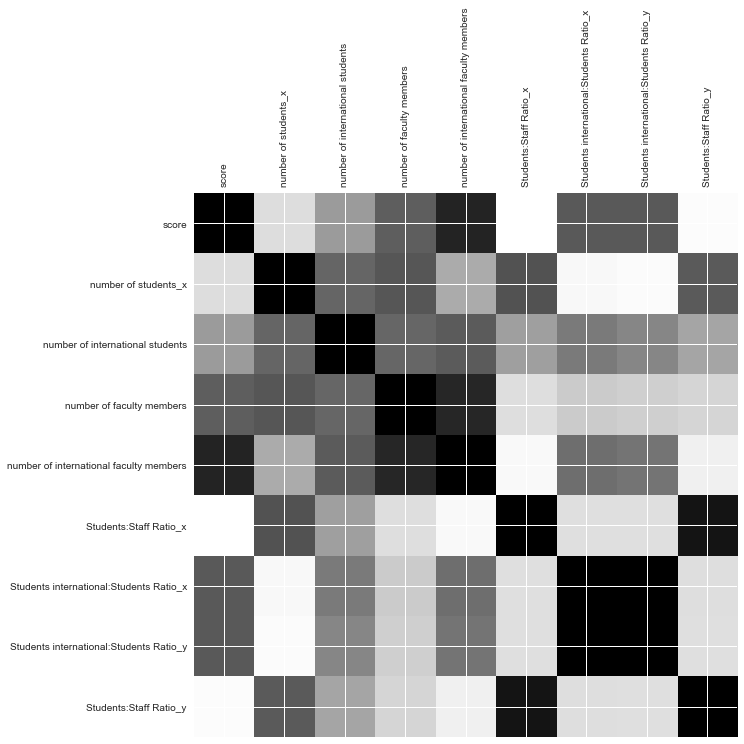

In [173]:
plot_corr(mergednotnull.corr())